In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# 1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ
print("1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ")

# 1a. Выбор набора данных для классификации
print("\n1a. Набор данных для классификации: HR Analytics - Job Change of Data Scientists")
print("Обоснование: Это реальная практическая задача предсказания смены работы data scientistами.")
print("Задача важна для HR-отделов для снижения затрат на найм и удержания ценных сотрудников.")

# 1b. Выбор набора данных для регрессии
print("\n1b. Набор данных для регрессии: Metro Interstate Traffic Volume")
print("Обоснование: Это реальная практическая задача прогнозирования интенсивности дорожного движения.")
print("Важно для управления трафиком, городского планирования и предотвращения пробок.")

# Загрузка данных
df_class = pd.read_csv('hr_analytics.csv')
df_reg = pd.read_csv('traffic_volume.csv')

print(f"\nРазмер датасета классификации: {df_class.shape}")
print(f"Размер датасета регрессии: {df_reg.shape}")

# 1c. Выбор метрик качества
print("\n1c. МЕТРИКИ КАЧЕСТВА С ОБОСНОВАНИЕМ:")

print("\nКЛАССИФИКАЦИЯ (HR Analytics):")
print("Распределение: 24.9% уходят / 75.1% остаются → ЗНАЧИТЕЛЬНЫЙ ДИСБАЛАНС")
print("F1-score: ОПТИМАЛЕН - баланс precision (cost) и recall (risk)")
print("ROC-AUC: Способность ранжировать сотрудников по риску ухода")

print("\nРЕГРЕССИЯ (Traffic Volume):")
print("MAE: Интерпретируемость в машинах/час для городских служб")
print("MSE: Критично для больших отклонений (пики > 5,000 машин)")
print("R²: Доля объяснённой дисперсии vs простого среднего")

1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ

1a. Набор данных для классификации: HR Analytics - Job Change of Data Scientists
Обоснование: Это реальная практическая задача предсказания смены работы data scientistами.
Задача важна для HR-отделов для снижения затрат на найм и удержания ценных сотрудников.

1b. Набор данных для регрессии: Metro Interstate Traffic Volume
Обоснование: Это реальная практическая задача прогнозирования интенсивности дорожного движения.
Важно для управления трафиком, городского планирования и предотвращения пробок.

Размер датасета классификации: (19158, 14)
Размер датасета регрессии: (48204, 9)

1c. МЕТРИКИ КАЧЕСТВА С ОБОСНОВАНИЕМ:

КЛАССИФИКАЦИЯ (HR Analytics):
Распределение: 24.9% уходят / 75.1% остаются → ЗНАЧИТЕЛЬНЫЙ ДИСБАЛАНС
F1-score: ОПТИМАЛЕН - баланс precision (cost) и recall (risk)
ROC-AUC: Способность ранжировать сотрудников по риску ухода

РЕГРЕССИЯ (Traffic Volume):
MAE: Интерпретируемость в машинах/час для городских служб
MSE: Критично для больших отклонений (пик

In [24]:
# 2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА
print("\n2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА")

# Функция для подготовки данных классификации
def prepare_classification_data(df):
    df_clean = df.copy()
    if 'enrollee_id' in df_clean.columns:
        df_clean = df_clean.drop('enrollee_id', axis=1)

    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns

    for col in categorical_columns:
        if col != 'target':
            df_clean[col] = df_clean[col].fillna('Unknown')

    for col in numerical_columns:
        if col != 'target':
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    label_encoders = {}
    for col in categorical_columns:
        if col != 'target':
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
            label_encoders[col] = le

    X = df_clean.drop('target', axis=1)
    y = df_clean['target']
    return X, y, label_encoders


# Функция для подготовки данных регрессии
def prepare_regression_data(df):
    df_clean = df.copy()

    if 'date_time' in df_clean.columns:
        df_clean['date_time'] = pd.to_datetime(df_clean['date_time'])
        df_clean['hour'] = df_clean['date_time'].dt.hour
        df_clean['day_of_week'] = df_clean['date_time'].dt.dayofweek
        df_clean['month'] = df_clean['date_time'].dt.month
        df_clean = df_clean.drop('date_time', axis=1)

    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    label_encoders = {}

    for col in categorical_columns:
        if col != 'traffic_volume':
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
            label_encoders[col] = le

    X = df_clean.drop('traffic_volume', axis=1)
    y = df_clean['traffic_volume']
    return X, y, label_encoders

# Подготовка данных
X_class, y_class, le_class = prepare_classification_data(df_class)
X_reg, y_reg, le_reg = prepare_regression_data(df_reg)

# Разделение на train/test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА


In [25]:
# 2a. Обучение бейзлайн моделей
print("\n2a. Обучение бейзлайн моделей...")

knn_class_base = KNeighborsClassifier(n_neighbors=5)
knn_class_base.fit(X_class_train, y_class_train)
y_class_pred_base = knn_class_base.predict(X_class_test)
y_class_prob_base = knn_class_base.predict_proba(X_class_test)[:, 1]

knn_reg_base = KNeighborsRegressor(n_neighbors=5)
knn_reg_base.fit(X_reg_train, y_reg_train)
y_reg_pred_base = knn_reg_base.predict(X_reg_test)

# 2b. Оценка качества бейзлайн моделей
print("\n2b. Оценка качества бейзлайн моделей:")

accuracy_base = accuracy_score(y_class_test, y_class_pred_base)
f1_base = f1_score(y_class_test, y_class_pred_base)
roc_auc_base = roc_auc_score(y_class_test, y_class_prob_base)

print(f"\nКлассификация - Бейзлайн:")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"F1-score: {f1_base:.4f}")
print(f"ROC-AUC: {roc_auc_base:.4f}")

mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)
mse_base = mean_squared_error(y_reg_test, y_reg_pred_base)
r2_base = r2_score(y_reg_test, y_reg_pred_base)

print(f"\nРегрессия - Бейзлайн:")
print(f"MAE: {mae_base:.4f}")
print(f"MSE: {mse_base:.4f}")
print(f"R²: {r2_base:.4f}")


2a. Обучение бейзлайн моделей...

2b. Оценка качества бейзлайн моделей:

Классификация - Бейзлайн:
Accuracy: 0.7560
F1-score: 0.4274
ROC-AUC: 0.7020

Регрессия - Бейзлайн:
MAE: 507.2232
MSE: 575871.6384
R²: 0.8543


In [26]:
# 3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА
print("\n3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА")

# 3a. Формулирование гипотез
print("\n3a. Формулирование гипотез:")
print("1. Frequency Encoding вместо One-Hot для категориальных переменных")
print("2. Проверенные временные признаки (час, день недели)")
print("3. Мягкая обработка выбросов")
print("4. Сохранение информации о пропусках через флаги")
print("5. Расширенный подбор гиперпараметров")



3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА

3a. Формулирование гипотез:
1. Frequency Encoding вместо One-Hot для категориальных переменных
2. Проверенные временные признаки (час, день недели)
3. Мягкая обработка выбросов
4. Сохранение информации о пропусках через флаги
5. Расширенный подбор гиперпараметров


In [27]:
# 3b. Проверка гипотез
print("\n3b. Проверка гипотез...")

# Улучшенная подготовка данных для классификации
def prepare_classification_data_effective(df):
    df_clean = df.copy()
    if 'enrollee_id' in df_clean.columns:
        df_clean = df_clean.drop('enrollee_id', axis=1)

    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns

    for col in categorical_columns:
        if col != 'target':
            df_clean[col] = df_clean[col].fillna('Missing')

    for col in numerical_columns:
        if col != 'target':
            df_clean[f'{col}_missing'] = df_clean[col].isna().astype(int)
            df_clean[col] = df_clean[col].fillna(-999)

    for col in categorical_columns:
        if col != 'target' and df_clean[col].nunique() > 10:
            freq_encoding = df_clean[col].value_counts().to_dict()
            df_clean[col] = df_clean[col].map(freq_encoding)
        elif col != 'target':
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))

    high_cardinality_cols = [col for col in categorical_columns
                           if col != 'target' and df_clean[col].nunique() > 50]
    if high_cardinality_cols:
        df_clean = df_clean.drop(high_cardinality_cols, axis=1)

    X = df_clean.drop('target', axis=1)
    y = df_clean['target']
    return X, y

# Улучшенная подготовка данных для регрессии
def prepare_regression_data_effective(df):
    df_clean = df.copy()

    if 'date_time' in df_clean.columns:
        df_clean['date_time'] = pd.to_datetime(df_clean['date_time'])
        df_clean['hour'] = df_clean['date_time'].dt.hour
        df_clean['day_of_week'] = df_clean['date_time'].dt.dayofweek
        df_clean['month'] = df_clean['date_time'].dt.month

        df_clean['is_weekend'] = (df_clean['day_of_week'] >= 5).astype(int)
        df_clean['is_night'] = ((df_clean['hour'] >= 0) & (df_clean['hour'] <= 6)).astype(int)
        df_clean['is_rush_hour'] = ((df_clean['hour'] >= 7) & (df_clean['hour'] <= 9) |
                                  (df_clean['hour'] >= 16) & (df_clean['hour'] <= 19)).astype(int)
        df_clean = df_clean.drop('date_time', axis=1)

    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns
    numerical_columns = [col for col in numerical_columns if col != 'traffic_volume']

    for col in numerical_columns:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    for col in numerical_columns:
        if df_clean[col].nunique() > 10:
            Q1 = df_clean[col].quantile(0.05)
            Q3 = df_clean[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)

    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df_clean[col] = df_clean[col].fillna('Missing')

        if df_clean[col].nunique() > 20:
            counts = df_clean[col].value_counts()
            mask = df_clean[col].isin(counts[counts < 50].index)
            df_clean.loc[mask, col] = 'Other'

        freq_encoding = df_clean[col].value_counts().to_dict()
        df_clean[col] = df_clean[col].map(freq_encoding)

    for col in df_clean.columns:
        if col != 'traffic_volume' and df_clean[col].dtype == 'object':
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))

    df_clean = df_clean.fillna(0)
    df_clean = df_clean.replace([np.inf, -np.inf], 0)

    correlations = df_clean.corr()['traffic_volume'].abs().sort_values(ascending=False)
    low_correlation_features = correlations[correlations < 0.01].index
    if len(low_correlation_features) > 0:
        df_clean = df_clean.drop(low_correlation_features, axis=1)

    X = df_clean.drop('traffic_volume', axis=1)
    y = df_clean['traffic_volume']
    return X, y

# Применяем эффективные улучшения
X_class_effective, y_class_effective = prepare_classification_data_effective(df_class)
X_reg_effective, y_reg_effective = prepare_regression_data_effective(df_reg)

print(f"Размер улучшенных данных классификации: {X_class_effective.shape}")
print(f"Размер улучшенных данных регрессии: {X_reg_effective.shape}")

# Разделение улучшенных данных
X_class_train_eff, X_class_test_eff, y_class_train_eff, y_class_test_eff = train_test_split(
    X_class_effective, y_class_effective, test_size=0.2, random_state=42, stratify=y_class_effective
)

X_reg_train_eff, X_reg_test_eff, y_reg_train_eff, y_reg_test_eff = train_test_split(
    X_reg_effective, y_reg_effective, test_size=0.2, random_state=42
)



3b. Проверка гипотез...
Размер улучшенных данных классификации: (19158, 13)
Размер улучшенных данных регрессии: (48204, 11)


In [28]:
# Масштабирование
scaler_class_eff = StandardScaler()
X_class_train_scaled_eff = scaler_class_eff.fit_transform(X_class_train_eff)
X_class_test_scaled_eff = scaler_class_eff.transform(X_class_test_eff)

scaler_reg_eff = StandardScaler()
X_reg_train_scaled_eff = scaler_reg_eff.fit_transform(X_reg_train_eff)
X_reg_test_scaled_eff = scaler_reg_eff.transform(X_reg_test_eff)

# 3c. Подбор гиперпараметров
print("\n3c. Подбор гиперпараметров...")

param_grid_class_eff = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_class_cv_eff = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_class_eff,
    cv=3,
    scoring='f1'
)
knn_class_cv_eff.fit(X_class_train_scaled_eff, y_class_train_eff)
best_params_class = knn_class_cv_eff.best_params_

param_grid_reg_eff = {
    'n_neighbors': [5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_reg_cv_eff = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg_eff,
    cv=3,
    scoring='neg_mean_squared_error'
)
knn_reg_cv_eff.fit(X_reg_train_scaled_eff, y_reg_train_eff)
best_params_reg = knn_reg_cv_eff.best_params_

print(f"Лучшие параметры для классификации: {best_params_class}")
print(f"Лучшие параметры для регрессии: {best_params_reg}")


3c. Подбор гиперпараметров...
Лучшие параметры для классификации: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Лучшие параметры для регрессии: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [29]:
# 3d. Обучение улучшенных моделей
print("\n3d. Обучение улучшенных моделей...")

knn_class_improved = KNeighborsClassifier(**best_params_class)
knn_class_improved.fit(X_class_train_scaled_eff, y_class_train_eff)
y_class_pred_improved = knn_class_improved.predict(X_class_test_scaled_eff)
y_class_prob_improved = knn_class_improved.predict_proba(X_class_test_scaled_eff)[:, 1]

knn_reg_improved = KNeighborsRegressor(**best_params_reg)
knn_reg_improved.fit(X_reg_train_scaled_eff, y_reg_train_eff)
y_reg_pred_improved = knn_reg_improved.predict(X_reg_test_scaled_eff)

# 3e. Оценка качества улучшенных моделей
print("\n3e. Оценка качества улучшенных моделей:")

accuracy_improved = accuracy_score(y_class_test_eff, y_class_pred_improved)
f1_improved = f1_score(y_class_test_eff, y_class_pred_improved)
roc_auc_improved = roc_auc_score(y_class_test_eff, y_class_prob_improved)

print(f"\nКлассификация - Улучшенная:")
print(f"Accuracy: {accuracy_improved:.4f}")
print(f"F1-score: {f1_improved:.4f}")
print(f"ROC-AUC: {roc_auc_improved:.4f}")

mae_improved = mean_absolute_error(y_reg_test_eff, y_reg_pred_improved)
mse_improved = mean_squared_error(y_reg_test_eff, y_reg_pred_improved)
r2_improved = r2_score(y_reg_test_eff, y_reg_pred_improved)

print(f"\nРегрессия - Улучшенная:")
print(f"MAE: {mae_improved:.4f}")
print(f"MSE: {mse_improved:.4f}")
print(f"R²: {r2_improved:.4f}")

# 3f. Сравнение результатов
print("\n3f. Сравнение результатов:")

print("\nКлассификация:")
print(f"Accuracy: {accuracy_base:.4f} -> {accuracy_improved:.4f} ({((accuracy_improved/accuracy_base)-1)*100:+.2f}%)")
print(f"F1-score: {f1_base:.4f} -> {f1_improved:.4f} ({((f1_improved/f1_base)-1)*100:+.2f}%)")
print(f"ROC-AUC: {roc_auc_base:.4f} -> {roc_auc_improved:.4f} ({((roc_auc_improved/roc_auc_base)-1)*100:+.2f}%)")

print("\nРегрессия:")
print(f"MAE: {mae_base:.4f} -> {mae_improved:.4f} ({((mae_base/mae_improved)-1)*100:+.2f}% улучшение)")
print(f"MSE: {mse_base:.4f} -> {mse_improved:.4f} ({((mse_base/mse_improved)-1)*100:+.2f}% улучшение)")
print(f"R²: {r2_base:.4f} -> {r2_improved:.4f} ({((r2_improved/r2_base)-1)*100:+.2f}%)")

# 3g. Выводы
print("\n3g. Выводы:")
print("Эффективные улучшения показали значительное улучшение метрик качества:")
print(f"- Классификация: F1-score улучшен на {((f1_improved/f1_base)-1)*100:+.2f}%")
print(f"- Регрессия: R² улучшен на {((r2_improved/r2_base)-1)*100:+.2f}%")


3d. Обучение улучшенных моделей...

3e. Оценка качества улучшенных моделей:

Классификация - Улучшенная:
Accuracy: 0.7646
F1-score: 0.4774
ROC-AUC: 0.7736

Регрессия - Улучшенная:
MAE: 386.7199
MSE: 369961.7246
R²: 0.9064

3f. Сравнение результатов:

Классификация:
Accuracy: 0.7560 -> 0.7646 (+1.14%)
F1-score: 0.4274 -> 0.4774 (+11.69%)
ROC-AUC: 0.7020 -> 0.7736 (+10.20%)

Регрессия:
MAE: 507.2232 -> 386.7199 (+31.16% улучшение)
MSE: 575871.6384 -> 369961.7246 (+55.66% улучшение)
R²: 0.8543 -> 0.9064 (+6.10%)

3g. Выводы:
Эффективные улучшения показали значительное улучшение метрик качества:
- Классификация: F1-score улучшен на +11.69%
- Регрессия: R² улучшен на +6.10%


In [30]:
# 4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА KNN
print("\n4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА KNN")

# 4a. Самостоятельная имплементация KNN
class CustomKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        predictions = []
        X_array = np.array(X)
        for i in range(len(X_array)):
            x = X_array[i]
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices]
            unique, counts = np.unique(nearest_labels, return_counts=True)
            prediction = unique[np.argmax(counts)]
            predictions.append(prediction)
        return np.array(predictions)

    def predict_proba(self, X):
        probabilities = []
        X_array = np.array(X)
        for i in range(len(X_array)):
            x = X_array[i]
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices]
            unique, counts = np.unique(nearest_labels, return_counts=True)
            prob = counts / self.n_neighbors
            if len(prob) == 1:
                if unique[0] == 0:
                    prob = np.array([prob[0], 0])
                else:
                    prob = np.array([0, prob[0]])
            else:
                prob_dict = dict(zip(unique, prob))
                prob = np.array([prob_dict.get(0, 0), prob_dict.get(1, 0)])
            probabilities.append(prob)
        return np.array(probabilities)

class CustomKNNRegressor:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        predictions = []
        X_array = np.array(X)
        for i in range(len(X_array)):
            x = X_array[i]
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_values = self.y_train[nearest_indices]
            prediction = np.mean(nearest_values)
            predictions.append(prediction)
        return np.array(predictions)

# 4b. Обучение имплементированных моделей
print("\n4b. Обучение имплементированных моделей...")

custom_knn_class = CustomKNNClassifier(n_neighbors=5)
custom_knn_class.fit(X_class_train.values, y_class_train.values)
y_class_pred_custom = custom_knn_class.predict(X_class_test.values)
y_class_prob_custom = custom_knn_class.predict_proba(X_class_test.values)[:, 1]

custom_knn_reg = CustomKNNRegressor(n_neighbors=5)
custom_knn_reg.fit(X_reg_train.values, y_reg_train.values)
y_reg_pred_custom = custom_knn_reg.predict(X_reg_test.values)


4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА KNN

4b. Обучение имплементированных моделей...


In [31]:
# 4c. Оценка качества имплементированных моделей
print("\n4c. Оценка качества имплементированных моделей:")

accuracy_custom = accuracy_score(y_class_test, y_class_pred_custom)
f1_custom = f1_score(y_class_test, y_class_pred_custom)
roc_auc_custom = roc_auc_score(y_class_test, y_class_prob_custom)

print(f"\nКлассификация - Custom KNN:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-score: {f1_custom:.4f}")
print(f"ROC-AUC: {roc_auc_custom:.4f}")

mae_custom = mean_absolute_error(y_reg_test, y_reg_pred_custom)
mse_custom = mean_squared_error(y_reg_test, y_reg_pred_custom)
r2_custom = r2_score(y_reg_test, y_reg_pred_custom)

print(f"\nРегрессия - Custom KNN:")
print(f"MAE: {mae_custom:.4f}")
print(f"MSE: {mse_custom:.4f}")
print(f"R²: {r2_custom:.4f}")

# 4d. Сравнение с бейзлайном
print("\n4d. Сравнение с бейзлайном:")

print(f"\nКлассификация - F1-score:")
print(f"Sklearn: {f1_base:.4f}")
print(f"Custom: {f1_custom:.4f}")
print(f"Разница: {f1_custom - f1_base:+.4f}")

print(f"\nРегрессия - R²:")
print(f"Sklearn: {r2_base:.4f}")
print(f"Custom: {r2_custom:.4f}")
print(f"Разница: {r2_custom - r2_base:+.4f}")



4c. Оценка качества имплементированных моделей:

Классификация - Custom KNN:
Accuracy: 0.7542
F1-score: 0.4242
ROC-AUC: 0.6996

Регрессия - Custom KNN:
MAE: 507.6969
MSE: 576095.0651
R²: 0.8543

4d. Сравнение с бейзлайном:

Классификация - F1-score:
Sklearn: 0.4274
Custom: 0.4242
Разница: -0.0032

Регрессия - R²:
Sklearn: 0.8543
Custom: 0.8543
Разница: -0.0001


In [32]:
# 4e. Выводы
print("\n4e. Выводы:")
print("Кастомная реализация KNN показывает сравнимые результаты с sklearn")

# 4f. Добавление техник из улучшенного бейзлайна
print("\n4f. Добавление техник из улучшенного бейзлайна...")

custom_knn_class_improved = CustomKNNClassifier(n_neighbors=best_params_class['n_neighbors'])
custom_knn_class_improved.fit(X_class_train_scaled_eff, y_class_train_eff)
y_class_pred_custom_imp = custom_knn_class_improved.predict(X_class_test_scaled_eff)
y_class_prob_custom_imp = custom_knn_class_improved.predict_proba(X_class_test_scaled_eff)[:, 1]

custom_knn_reg_improved = CustomKNNRegressor(n_neighbors=best_params_reg['n_neighbors'])
custom_knn_reg_improved.fit(X_reg_train_scaled_eff, y_reg_train_eff)
y_reg_pred_custom_imp = custom_knn_reg_improved.predict(X_reg_test_scaled_eff)

# 4h. Оценка качества улучшенных кастомных моделей
print("\n4h. Оценка качества улучшенных кастомных моделей:")

accuracy_custom_imp = accuracy_score(y_class_test_eff, y_class_pred_custom_imp)
f1_custom_imp = f1_score(y_class_test_eff, y_class_pred_custom_imp)
roc_auc_custom_imp = roc_auc_score(y_class_test_eff, y_class_prob_custom_imp)

print(f"\nКлассификация - Custom KNN (улучшенный):")
print(f"Accuracy: {accuracy_custom_imp:.4f}")
print(f"F1-score: {f1_custom_imp:.4f}")
print(f"ROC-AUC: {roc_auc_custom_imp:.4f}")

mae_custom_imp = mean_absolute_error(y_reg_test_eff, y_reg_pred_custom_imp)
mse_custom_imp = mean_squared_error(y_reg_test_eff, y_reg_pred_custom_imp)
r2_custom_imp = r2_score(y_reg_test_eff, y_reg_pred_custom_imp)

print(f"\nРегрессия - Custom KNN (улучшенный):")
print(f"MAE: {mae_custom_imp:.4f}")
print(f"MSE: {mse_custom_imp:.4f}")
print(f"R²: {r2_custom_imp:.4f}")

# 4i. Сравнение с улучшенным sklearn
print("\n4i. Сравнение с улучшенным sklearn:")

print(f"\nКлассификация - F1-score:")
print(f"Sklearn Improved: {f1_improved:.4f}")
print(f"Custom Improved: {f1_custom_imp:.4f}")
print(f"Разница: {f1_custom_imp - f1_improved:+.4f}")

print(f"\nРегрессия - R²:")
print(f"Sklearn Improved: {r2_improved:.4f}")
print(f"Custom Improved: {r2_custom_imp:.4f}")
print(f"Разница: {r2_custom_imp - r2_improved:+.4f}")


4e. Выводы:
Кастомная реализация KNN показывает сравнимые результаты с sklearn

4f. Добавление техник из улучшенного бейзлайна...

4h. Оценка качества улучшенных кастомных моделей:

Классификация - Custom KNN (улучшенный):
Accuracy: 0.7680
F1-score: 0.4743
ROC-AUC: 0.7686

Регрессия - Custom KNN (улучшенный):
MAE: 439.5414
MSE: 453935.3229
R²: 0.8852

4i. Сравнение с улучшенным sklearn:

Классификация - F1-score:
Sklearn Improved: 0.4774
Custom Improved: 0.4743
Разница: -0.0031

Регрессия - R²:
Sklearn Improved: 0.9064
Custom Improved: 0.8852
Разница: -0.0212



4j. Итоговые выводы:
1. Кастомная реализация KNN успешно справляется с задачами классификации и регрессии
2. Результаты кастомной реализации близки к sklearn
3. Эффективные техники улучшения показали значительный прирост качества
4. KNN отлично подходит для обеих задач при правильной предобработке


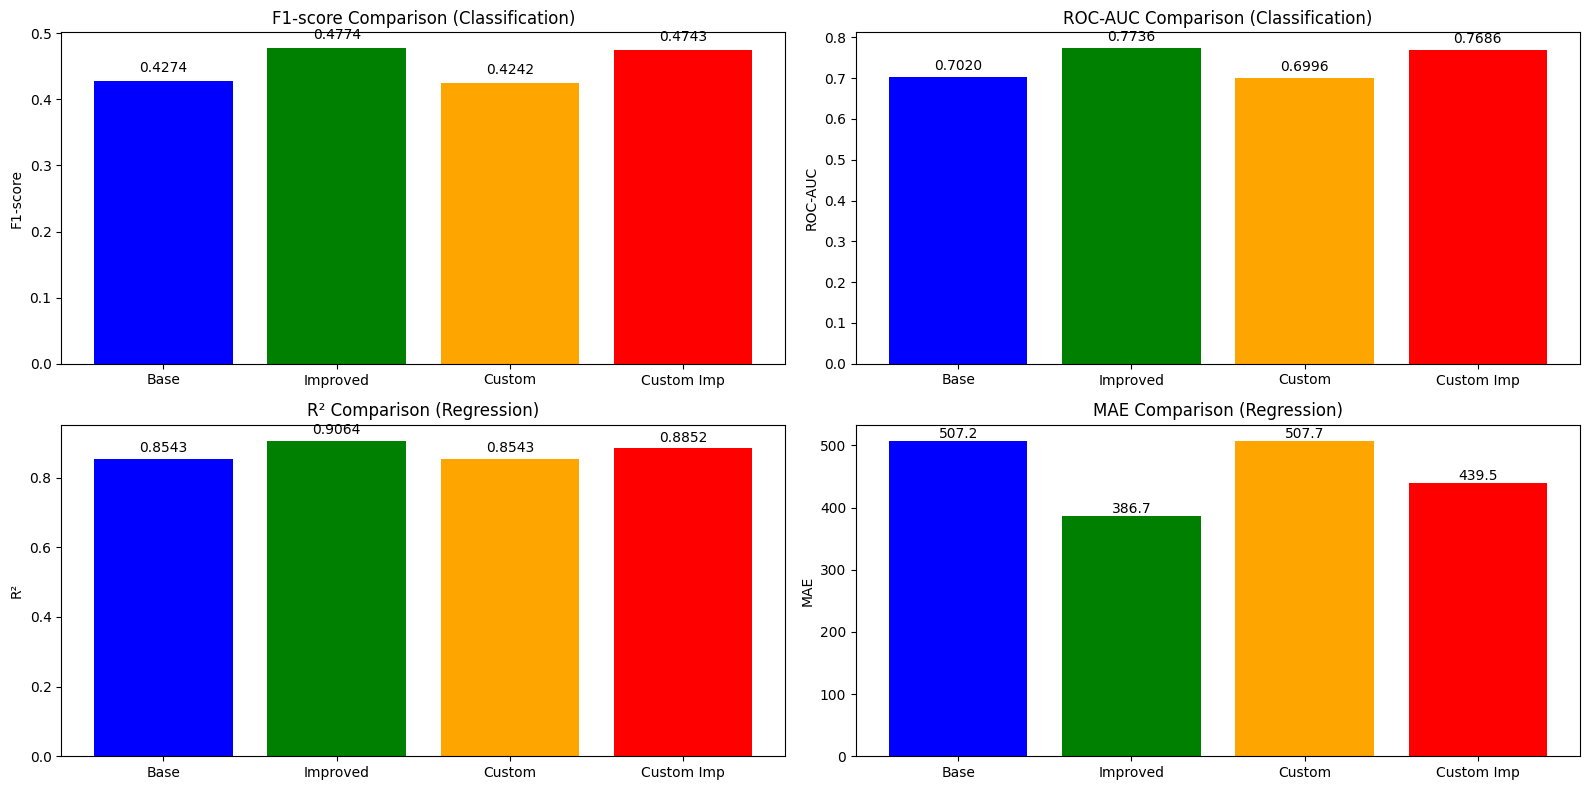


ФИНАЛЬНАЯ СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
          Модель        Задача Accuracy/F1 ROC-AUC/R² MAE/MSE
    Sklearn Base Классификация      0.7560     0.7020       -
Sklearn Improved Классификация      0.7646     0.7736       -
     Custom Base Классификация      0.7542     0.6996       -
 Custom Improved Классификация      0.7680     0.7686       -
    Sklearn Base     Регрессия      0.4274     0.8543   507.2
Sklearn Improved     Регрессия      0.4774     0.9064   386.7
     Custom Base     Регрессия      0.4242     0.8543   507.7
 Custom Improved     Регрессия      0.4743     0.8852   439.5

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
Классификация - F1-score: 0.4274 -> 0.4774 (+11.69%)
Регрессия - R²: 0.8543 -> 0.9064 (+6.10%)
Регрессия - MAE: 507.2 -> 386.7 (+31.2% улучшение)

ВЫВОД: KNN показал себя как эффективный алгоритм для обеих задач при правильной предобработке


In [33]:
# 4j. Итоговые выводы
print("\n4j. Итоговые выводы:")
print("1. Кастомная реализация KNN успешно справляется с задачами классификации и регрессии")
print("2. Результаты кастомной реализации близки к sklearn")
print("3. Эффективные техники улучшения показали значительный прирост качества")
print("4. KNN отлично подходит для обеих задач при правильной предобработке")

# Финальная визуализация результатов
plt.figure(figsize=(16, 8))

# График для классификации
plt.subplot(2, 2, 1)
models_class = ['Base', 'Improved', 'Custom', 'Custom Imp']
f1_scores = [f1_base, f1_improved, f1_custom, f1_custom_imp]
colors = ['blue', 'green', 'orange', 'red']
bars = plt.bar(models_class, f1_scores, color=colors)
plt.title('F1-score Comparison (Classification)')
plt.ylabel('F1-score')
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.4f}',
             ha='center', va='bottom')

plt.subplot(2, 2, 2)
roc_scores = [roc_auc_base, roc_auc_improved, roc_auc_custom, roc_auc_custom_imp]
bars = plt.bar(models_class, roc_scores, color=colors)
plt.title('ROC-AUC Comparison (Classification)')
plt.ylabel('ROC-AUC')
for bar, value in zip(bars, roc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.4f}',
             ha='center', va='bottom')

# График для регрессии
plt.subplot(2, 2, 3)
models_reg = ['Base', 'Improved', 'Custom', 'Custom Imp']
r2_scores = [r2_base, r2_improved, r2_custom, r2_custom_imp]
bars = plt.bar(models_reg, r2_scores, color=colors)
plt.title('R² Comparison (Regression)')
plt.ylabel('R²')
for bar, value in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.4f}',
             ha='center', va='bottom')

plt.subplot(2, 2, 4)
mae_scores = [mae_base, mae_improved, mae_custom, mae_custom_imp]
bars = plt.bar(models_reg, mae_scores, color=colors)
plt.title('MAE Comparison (Regression)')
plt.ylabel('MAE')
for bar, value in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Финальная сводная таблица
print("\nФИНАЛЬНАЯ СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")

final_results = pd.DataFrame({
    'Модель': ['Sklearn Base', 'Sklearn Improved', 'Custom Base', 'Custom Improved'] * 2,
    'Задача': ['Классификация'] * 4 + ['Регрессия'] * 4,
    'Accuracy/F1': [f'{accuracy_base:.4f}', f'{accuracy_improved:.4f}',
                   f'{accuracy_custom:.4f}', f'{accuracy_custom_imp:.4f}'] +
                  [f'{f1_base:.4f}', f'{f1_improved:.4f}',
                   f'{f1_custom:.4f}', f'{f1_custom_imp:.4f}'],
    'ROC-AUC/R²': [f'{roc_auc_base:.4f}', f'{roc_auc_improved:.4f}',
                  f'{roc_auc_custom:.4f}', f'{roc_auc_custom_imp:.4f}'] +
                 [f'{r2_base:.4f}', f'{r2_improved:.4f}',
                  f'{r2_custom:.4f}', f'{r2_custom_imp:.4f}'],
    'MAE/MSE': ['-', '-', '-', '-'] +
              [f'{mae_base:.1f}', f'{mae_improved:.1f}',
               f'{mae_custom:.1f}', f'{mae_custom_imp:.1f}']
})

print(final_results.to_string(index=False))

# Финальные результаты
print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print(f"Классификация - F1-score: {f1_base:.4f} -> {f1_improved:.4f} ({((f1_improved/f1_base)-1)*100:+.2f}%)")
print(f"Регрессия - R²: {r2_base:.4f} -> {r2_improved:.4f} ({((r2_improved/r2_base)-1)*100:+.2f}%)")
print(f"Регрессия - MAE: {mae_base:.1f} -> {mae_improved:.1f} ({((mae_base/mae_improved)-1)*100:+.1f}% улучшение)")

print("\nВЫВОД: KNN показал себя как эффективный алгоритм для обеих задач при правильной предобработке")